In [11]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import matplotlib.pyplot as plt

In [12]:
dataset = pd.read_csv('../databases/Tcritical.csv', comment='#')
# dataset.shape[0]
dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.000001,1184.790,1184.790,1184.80,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.007501,1129.470,1129.470,1153.41,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.015000,1078.020,1078.020,1126.40,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.022500,1027.990,1027.990,1102.75,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.030000,978.821,978.821,1081.80,hipo


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf6dbb10f0>,
      dtype=object)

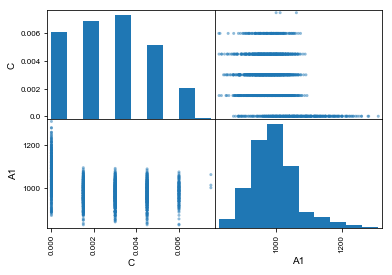

In [20]:
# sel = ~np.isnan(dataset.A3.values)
sel = ~np.isnan(dataset.A1.values) & (dataset.eutectoid == 'hipo')

scatter_matrix(dataset[['C', 'A1']][sel])

In [14]:
def fit_polynomial(tcrit, eutectoid, degree, reg=linear_model.LinearRegression()):
    
    if not eutectoid:
        sel = ~np.isnan(dataset[tcrit].values)
        
    else:
        sel = ~np.isnan(dataset[tcrit].values) & (dataset.eutectoid == eutectoid)
    
    filtered_dataset = dataset[sel]
    
    ind_var = np.vstack([filtered_dataset.C.values*100, 
                    filtered_dataset.Mn.values*100, 
                    filtered_dataset.Si.values*100, 
                    filtered_dataset.Cr.values*100, 
                    filtered_dataset.Ni.values*100]).transpose()
    
    dep_var = filtered_dataset[tcrit].values
    
    poly = PolynomialFeatures(degree=degree)
    ind_var_ = poly.fit_transform(ind_var)
    
#     reg = linear_model.Ridge(alpha=.5)
#     reg = linear_model.LinearRegression()
#     reg = linear_model.RANSACRegressor()
#     reg = linear_model.PassiveAggressiveRegressor()
    reg.fit(ind_var_, dep_var)
    
    fitting_summary = {
        'filtered_dataset': filtered_dataset,
        'poly': poly,
        'reg': reg,
        'dep_var': dep_var,
        'ind_var_': ind_var_
    }
    
    return fitting_summary

In [15]:
def get_coeficients(poly, clf, predict):
    print(poly.get_feature_names())
    
    print(reg.coef_)
    print(reg.intercept_)
    
    predict_ = poly.fit_transform(predict)
    print(reg.predict(predict_))

In [16]:
def plot_fit(dep_var, reg, ind_var_):
    plt.plot(dep_var, reg.predict(ind_var_), 'kx')
    Tmin, Tmax = np.min(dep_var), np.max(dep_var)
    plt.plot([Tmin, Tmax], [Tmin, Tmax], 'r-')    

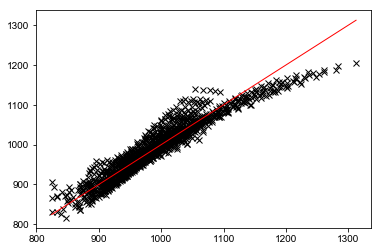

In [17]:
smry = fit_polynomial('A1', 'hipo', 2, reg=linear_model.LinearRegression())
plot_fit(smry['dep_var'], smry['reg'], smry['ind_var_'])
# smry['reg']
# smry['reg'].estimator_.coef_

Int64Index([   1,    2,    3,    4,    6,    7,    8,    9,   11,   12,
            ...
            3001, 3025, 3026, 3050, 3051, 3075, 3100, 3125, 3150, 3225],
           dtype='int64', length=1220)


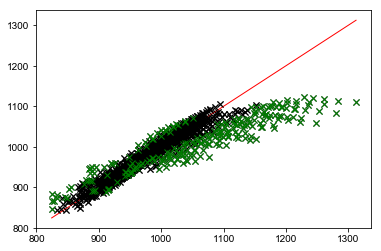

In [18]:
smry = fit_polynomial('A1', 'hipo', 2, reg=linear_model.RANSACRegressor())
plot_fit(smry['dep_var'], smry['reg'], smry['ind_var_'])

filtered_dataset = smry['filtered_dataset']
ransac = smry['reg']
dep_var = smry['dep_var']
ind_var_ = smry['ind_var_']

inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask

# print(len(filtered_dataset.index), len(inlier_mask))
print(filtered_dataset[inlier_mask].index)

plt.plot(dep_var[inlier_mask], ransac.predict(ind_var_)[inlier_mask], 'kx')
plt.plot(dep_var[outlier_mask], ransac.predict(ind_var_)[outlier_mask], 'gx')